# **Basic comparisons**

Ref: https://www.datacamp.com/tutorial/five-tips-r-code-improve

https://rstudio-pubs-static.s3.amazonaws.com/334570_37b3441798984dc4957c1ad6424e040b.html

In [ ]:
install.packages("microbenchmark")
library("microbenchmark")
library(glue)
library(ggplot2)
library(dplyr)
library(repr)
library(ggplot2)
options(repr.plot.width=15, repr.plot.height=7)
start_date <- "2017-01-01"
end_date <- "2019-12-31"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# function to calculate reduction
calcpecentage <- function(micro){
  v <- aggregate(time ~ expr, micro, mean)
  i <- 1
  j <- 2
  if(v$time[i] < v$time[j]){
    i <- 2
    j <- 1
  }
  reduction <- ((v$time[i] - v$time[j])*100)/v$time[i]
  reduction <- reduction |> round(digits = 2)
  return(glue("{reduction} % reduction using {v$expr[j]}"))
}

## **Sys time**

In [ ]:
.s <- Sys.time()
n_weeks <-  floor(as.numeric(difftime(end_date
                    , start_date, units="weeks")))
.e <- Sys.time()
.t <- capture.output(.e - .s)
print(glue("Total time: {.t} to get this result {n_weeks}"))

Total time: Time difference of 0.00363493 secs to get this result 156


In [ ]:
.s <- Sys.time()
n_weeks <- floor(as.numeric(difftime(as.Date(end_date)
            , as.Date(start_date), units = "weeks")))
.e <- Sys.time()
.t <- capture.output(.e - .s)
print(glue("Total time: {.t} to get this result {n_weeks}"))

Total time: Time difference of 0.003353596 secs to get this result 156


## **Cast date**

In [ ]:
f1<-function(d2, d1){
  n_weeks <-  floor(as.numeric(difftime(d2, d1, units="weeks")))
  # print(glue("Result 1: {n_weeks_in_scaling_period}"))
}
f2<-function(d2, d1){
  n_weeks <- floor(as.numeric(difftime(as.Date(d2)
    , as.Date(d1), units = "weeks")))
  # print(glue("Result 2: {n_weeks_in_scaling_period}"))
}
m1<-microbenchmark(
  Nocasting = f1(end_date, start_date),
  Casting = f2(end_date, start_date),
  times = 800
)
print(class(m1))
print(m1)

[1] "microbenchmark" "data.frame"    
Unit: microseconds
      expr     min      lq     mean   median       uq      max neval
 Nocasting 254.484 268.132 296.9778 276.9400 287.1605 4068.373   800
   Casting 111.269 117.455 142.8978 122.9595 131.4080 4288.266   800


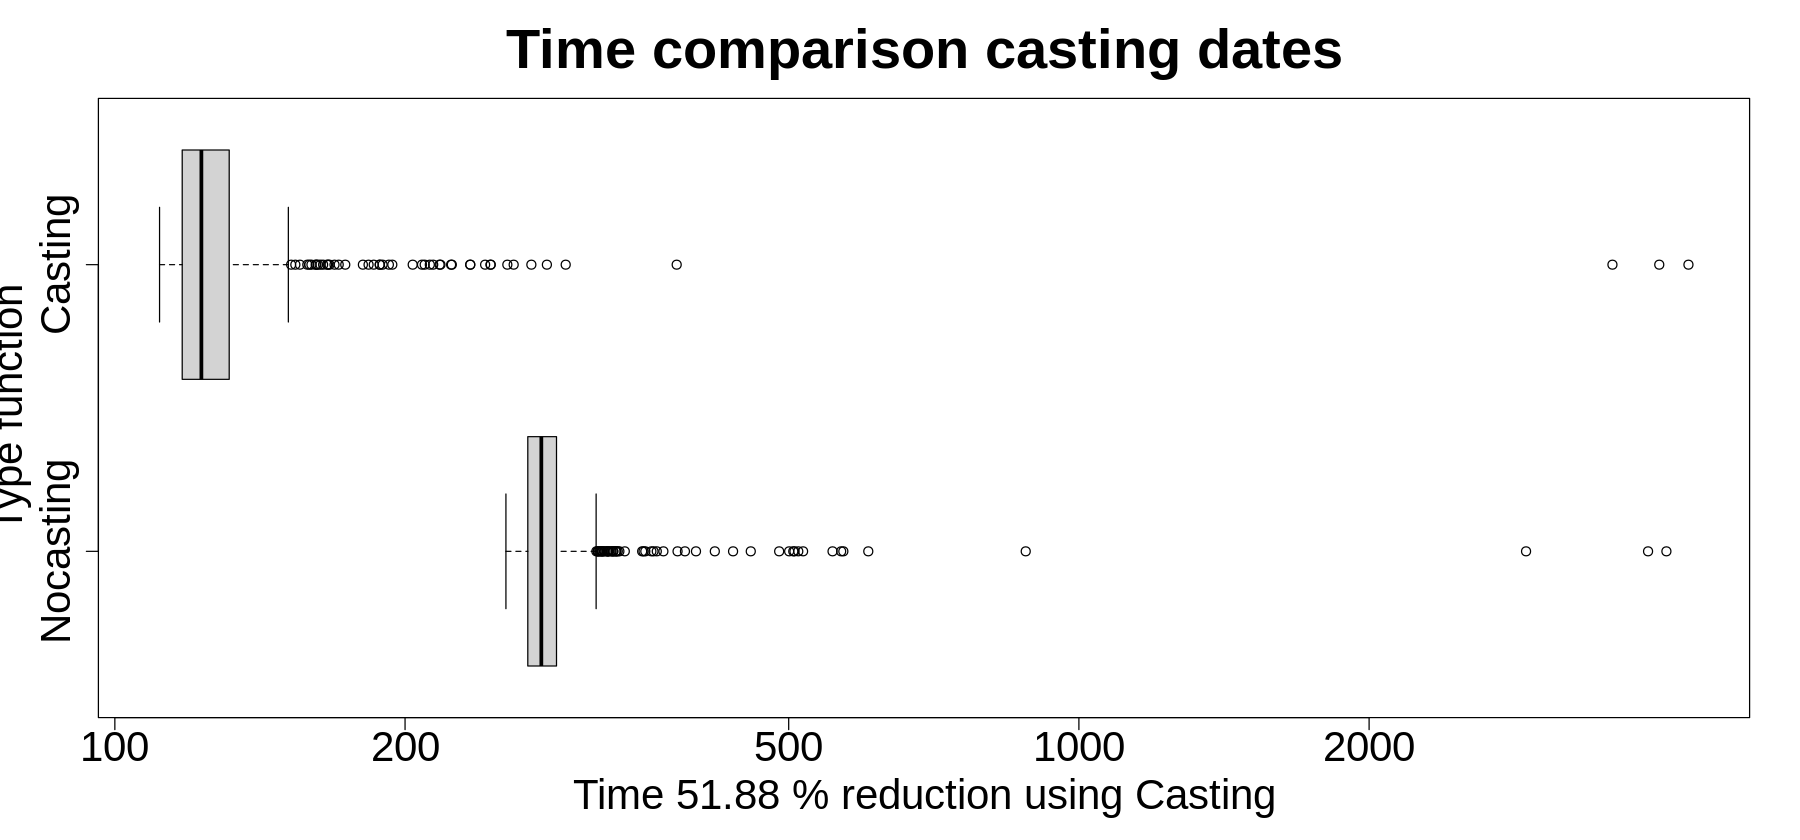

In [ ]:
m1 |> boxplot(horizontal = TRUE, main = 'Time comparison casting dates',
     ylab = glue('Time {calcpecentage(m1)}'), xlab = 'Type function',
     cex.main = 2.8, cex.lab = 2.1, cex.axis = 2.1)

## **Base code vs dplyr**

Let’s say we want to compare the execution time of two different methods for calculating the mean points scored by players on basketball teams.

In [ ]:
# Example data frame with points scored by players
set.seed(1)
mydemo <- data.frame(
  team = rep(c('A', 'B'), each = 4000),
  points =sample(1:100, 8000, replace = TRUE)
)
print(head(mydemo))

  team points
1    A     68
2    A     39
3    A      1
4    A     34
5    A     87
6    A     43


In [ ]:
base_r_time <- function(mydemo){
  x <- aggregate(mydemo$points, list(mydemo$team), FUN = mean)
  # print(x)
}
dplyr_time <- function(mydemo){
  x <- mydemo %>% group_by(team) %>% summarise_at(vars(points), list(name = mean))
  # print(x)
}
m2 <- microbenchmark(
  base = base_r_time(mydemo),
  dplyr = dplyr_time(mydemo),
  times = 30
)
print(m2)

Unit: milliseconds
  expr      min       lq     mean   median       uq       max neval
  base 3.476599 3.579906 4.271578 3.946108 4.633287  6.899577    30
 dplyr 6.382942 7.033701 9.236215 8.276104 8.711404 31.493557    30


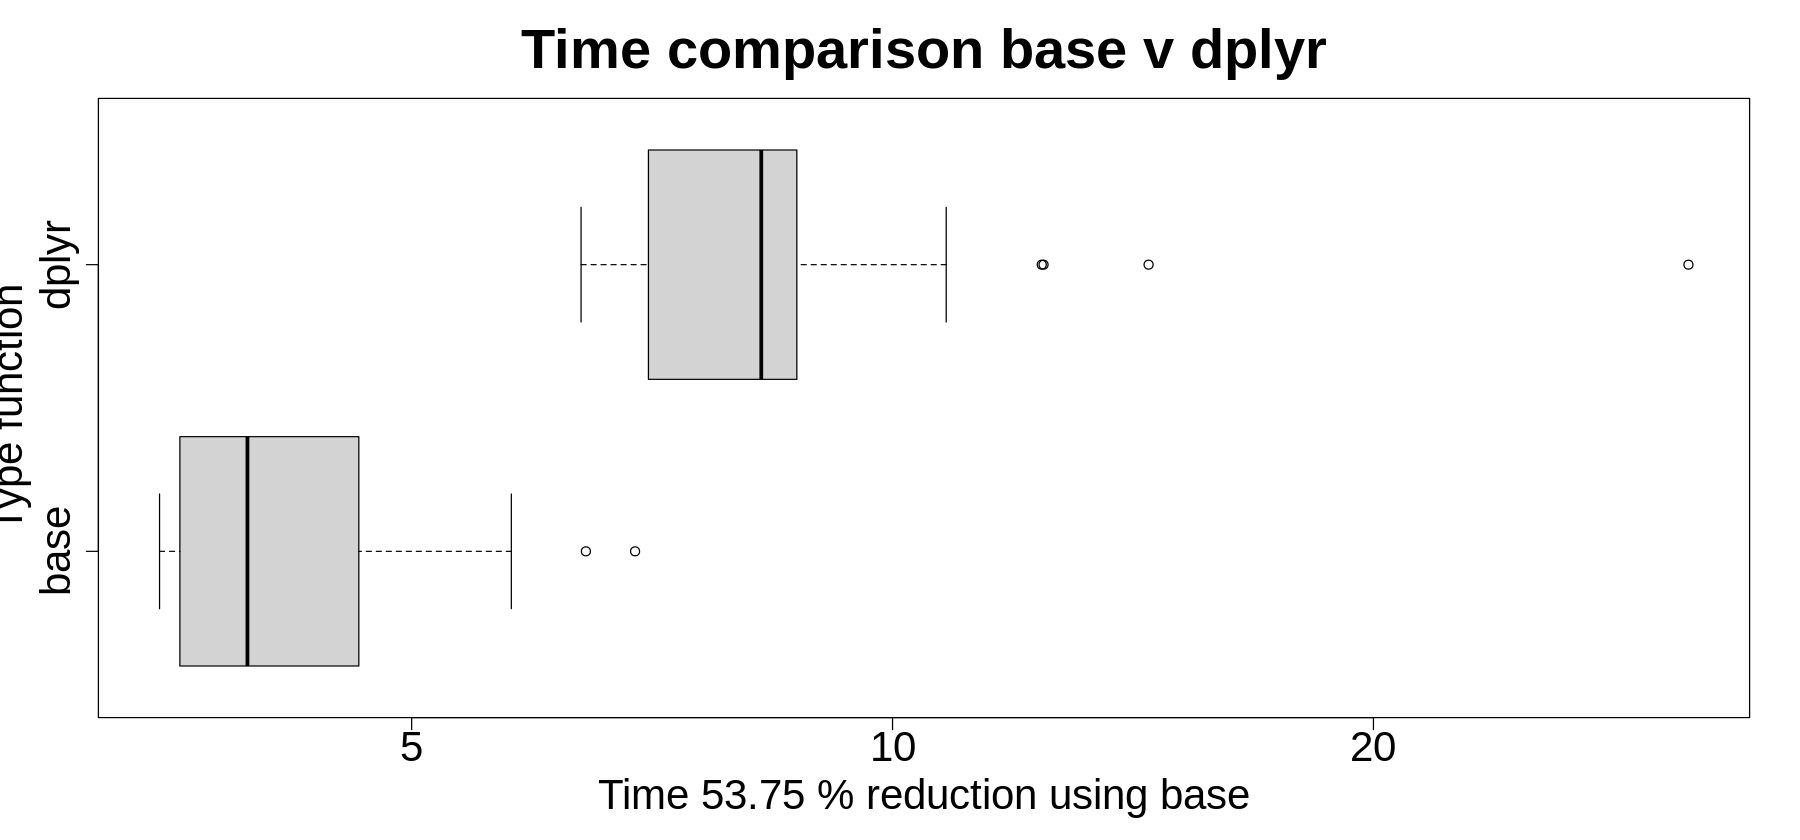

In [ ]:
m2 |>
boxplot(horizontal = TRUE, main = 'Time comparison base v dplyr',
     ylab = glue('Time {calcpecentage(m2)}'), xlab = 'Type function',
     cex.main = 2.8, cex.lab = 2.1, cex.axis = 2.1)

## **Next time you create an empty vector with c(), try to replace it with vector("type", length)**

Doing this improves memory usage and increases speed! You often know upfront what type of values will go into a vector, and how long the vector will be. Using c() means R has to slowly work both of these things out.

In [ ]:
x <- vector("numeric", 5)
print(x)

[1] 0 0 0 0 0


In [ ]:
f1 <- function (n){
  x <- c()
  for (i in seq(n)) {
    x <- c(x, i)
  }
  # print(x)
}
f2 <- function (n){
  x <- vector("integer", n)
  for (i in seq(n)) {
    x[i] <- i
  }
  # print(x)
}
m3 <- microbenchmark(
  nosize = f1(1e5),
  size = f2(1e5),
  times = 5
)
print(m3)

Unit: milliseconds
   expr          min           lq         mean       median           uq
 nosize 14696.543970 14729.725904 14923.109497 14852.940791 14923.656232
   size     4.934134     4.978517     5.859008     4.988469     5.101699
          max neval
 15412.680590     5
     9.292223     5


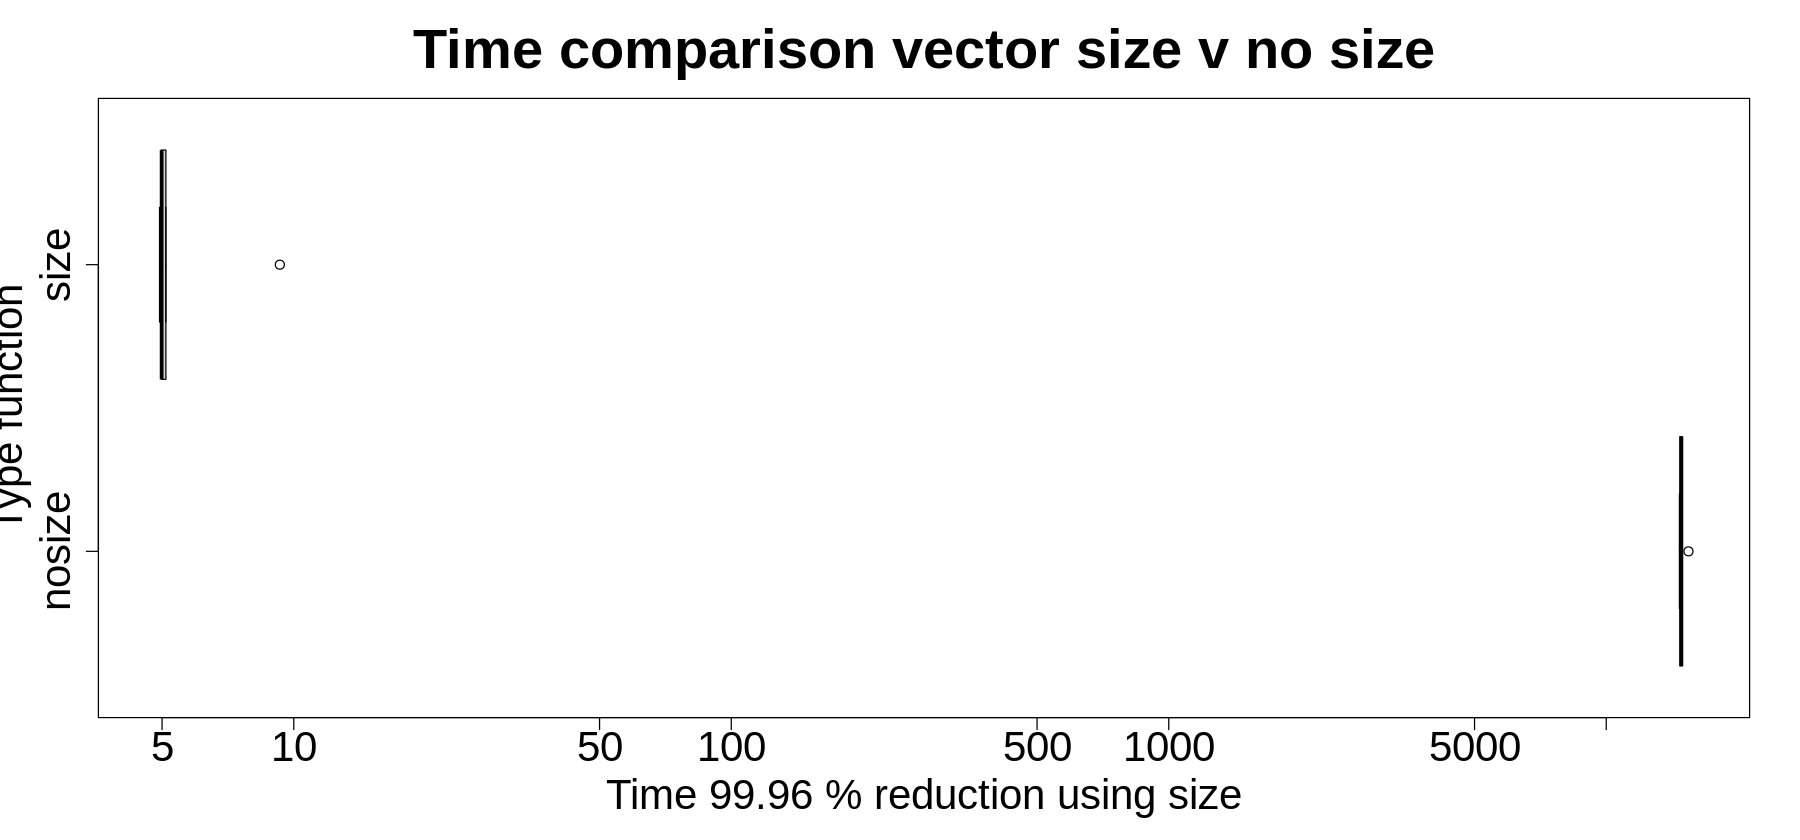

In [ ]:
m3 |>
boxplot(horizontal = TRUE, main = 'Time comparison vector size v no size',
     ylab = glue('Time {calcpecentage(m3)}'), xlab = 'Type function',
     cex.main = 2.8, cex.lab = 2.1, cex.axis = 2.1)

## **Ditch the which**

Why should you ditch which()? It's often unnecessary and boolean vectors are all you need.

In [ ]:
vector <- runif(1e8)
w1 <- function(x){
  d <- length(which(x > .5))
  # print(d)
}
w2 <- function(x){
  d <- sum(x > .5)
  # print(d)
}
m4 <- microbenchmark(
  which = w1(vector),
  nowhich = w2(vector),
  times = 10
)
print(m4)

Unit: milliseconds
    expr       min        lq      mean    median        uq       max neval
   which 1223.3669 1280.2540 1381.4777 1302.5427 1382.8054 2088.2793    10
 nowhich  552.7681  560.5468  649.2319  595.8663  757.6042  843.8184    10


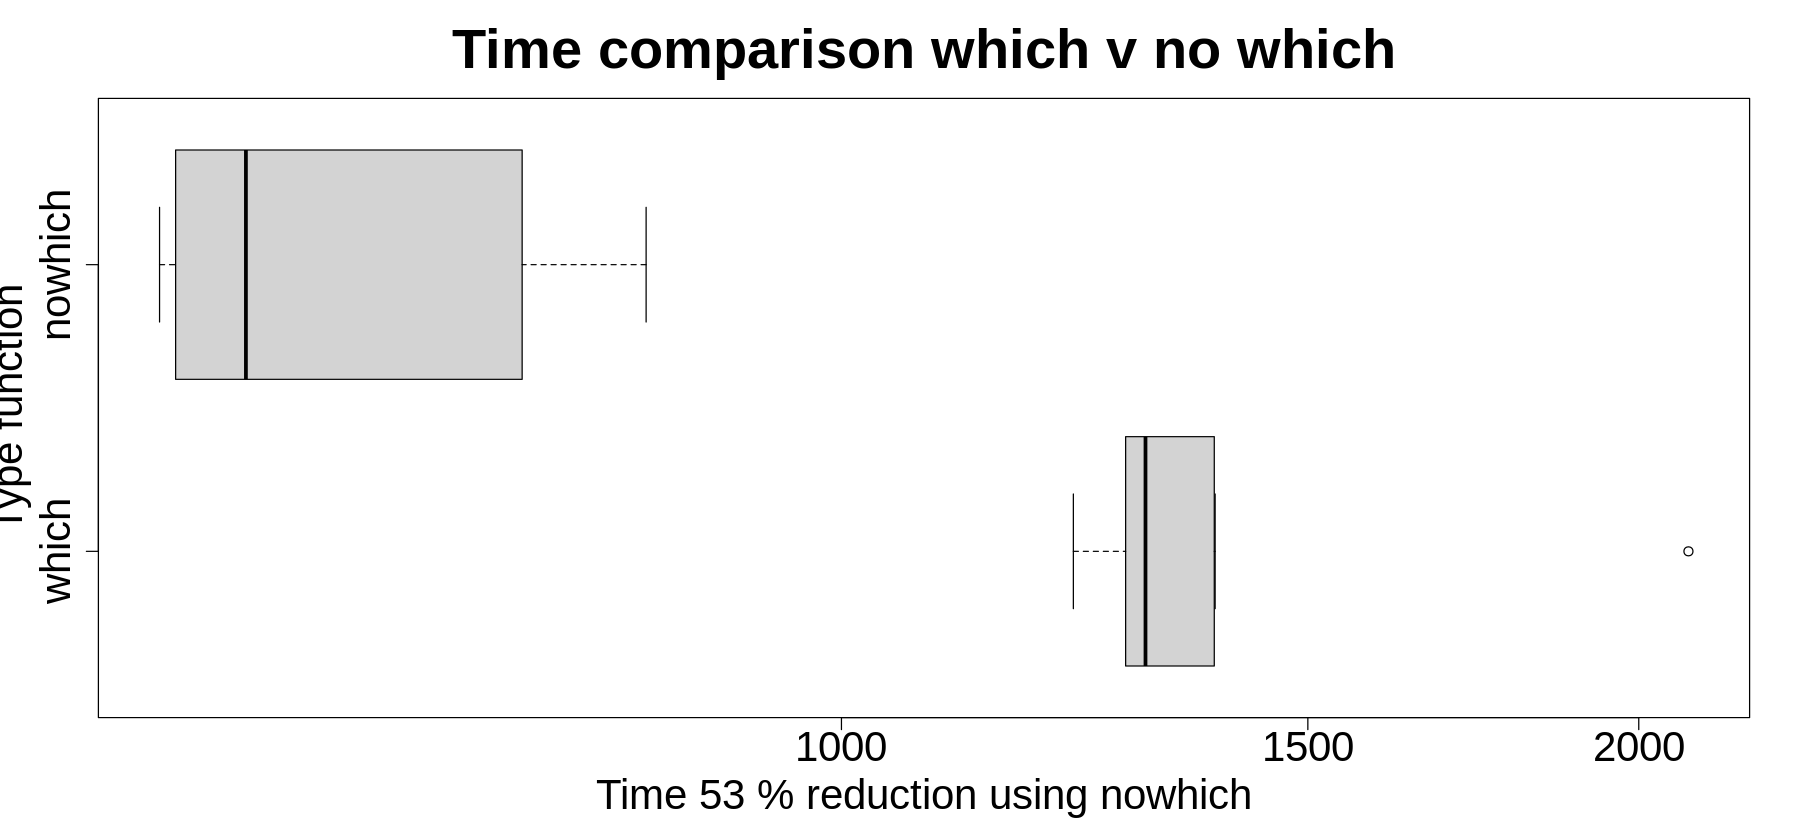

In [ ]:
m4 |>
boxplot(horizontal = TRUE, main = 'Time comparison which v no which',
     ylab = glue('Time {calcpecentage(m4)}'), xlab = 'Type function',
     cex.main = 2.8, cex.lab = 2.1, cex.axis = 2.1)

## **Column first**

When you specify column first, this means that you're now referring to a vector

In [ ]:
n <- 1e4
dt <- data.frame(
  a = seq(n),
  b = runif(n)
)
dt |>
  head()

,a,b
,<int>,<dbl>
1,1,0.4137689
2,2,0.5127842
3,3,0.8998371
4,4,0.7399335
5,5,0.9351460
6,6,0.4817588


In [ ]:
v1 <- function(dt){
  d <- mean(dt[dt$b > .5, ]$a)
  # print(d)
}
v2 <- function(dt){
  d <- mean(dt$a[dt$b > .5])
  # print(d)
}
m5 <- microbenchmark(
  row_operation = v1(dt),
  column_operation = v2(dt),
  times = 10
)
print(m5)

Unit: microseconds
             expr     min      lq     mean   median      uq      max neval
    row_operation 442.826 453.052 785.8641 476.8825 499.552 3550.344    10
 column_operation 113.088 113.912 424.3339 116.5950 133.091 2926.339    10


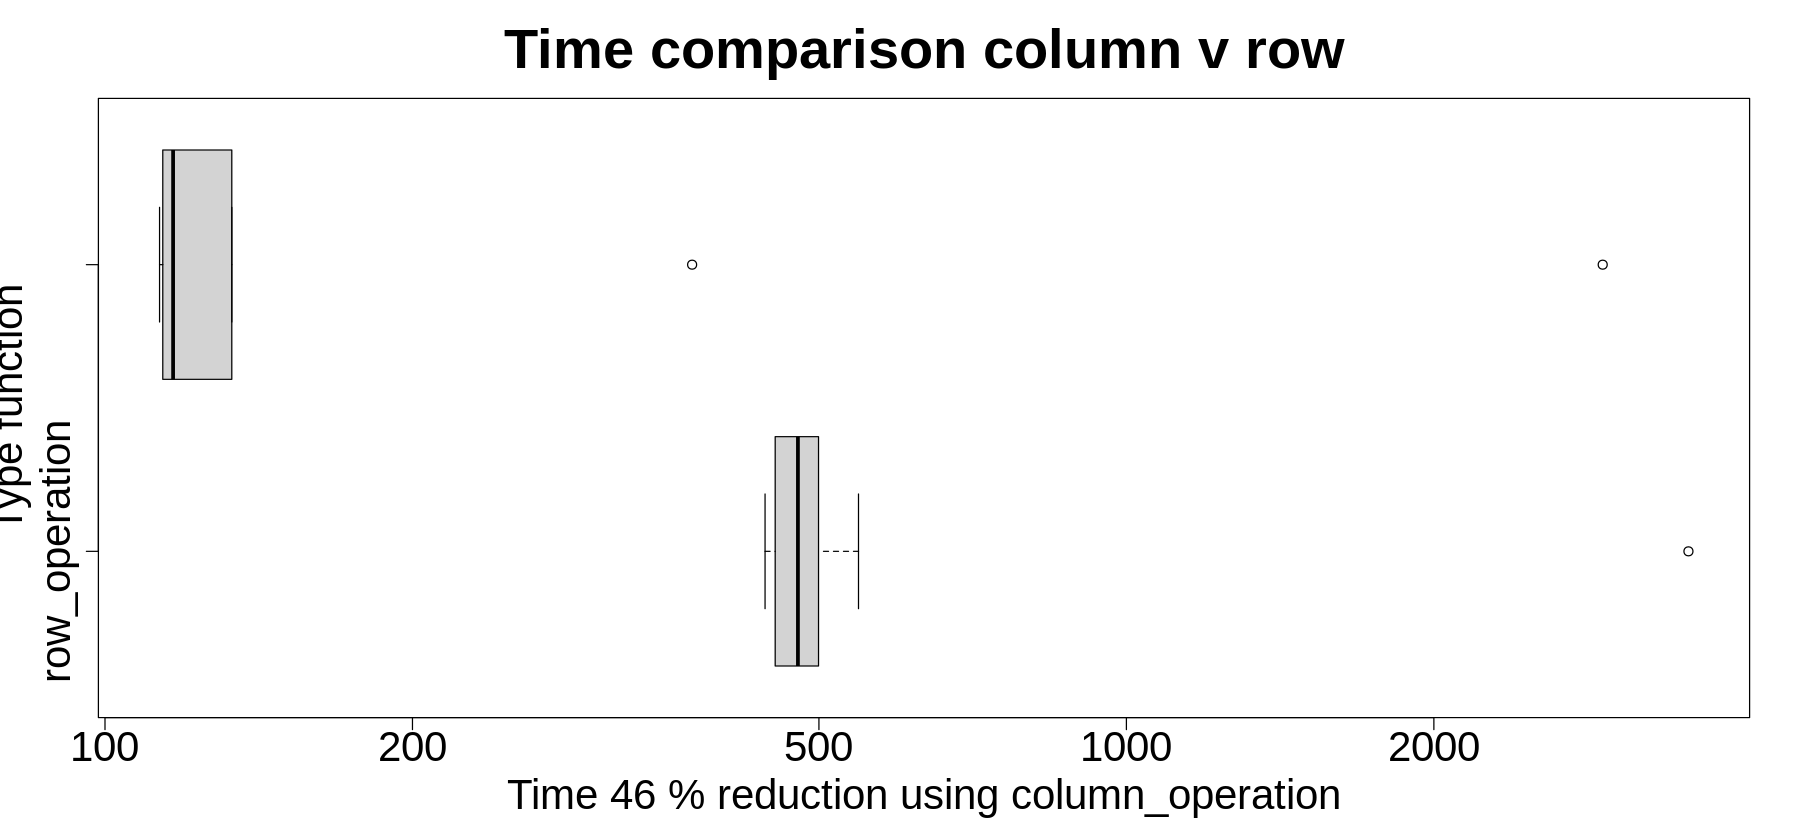

In [ ]:
m5 |>
boxplot(horizontal = TRUE, main = 'Time comparison column v row',
     ylab = glue('Time {calcpecentage(m5)}'), xlab = 'Type function',
     cex.main = 2.8, cex.lab = 2.1, cex.axis = 2.1)

## **Sequences**

Next time you use the colon operator to create a sequence from 1 like 1:n, try seq()

if you have x <- c() and you use 1:length(x) you will have 1 0

In [ ]:
num <- 1e7
s1 <- function(num){
  d <- mean(1:num)
  # print(d)
}
s2 <- function(num){
  d <- mean(seq(num))
  # print(d)
}
m6<-microbenchmark(
  noseq = s1(num),
  seq = s2(num),
  times = 20
)
print(m6)

Unit: milliseconds
  expr      min       lq     mean   median       uq      max neval
 noseq 59.96616 60.06498 61.98354 60.33702 63.27996 70.69963    20
   seq 60.00543 60.17193 61.43015 60.54478 61.31111 73.38586    20


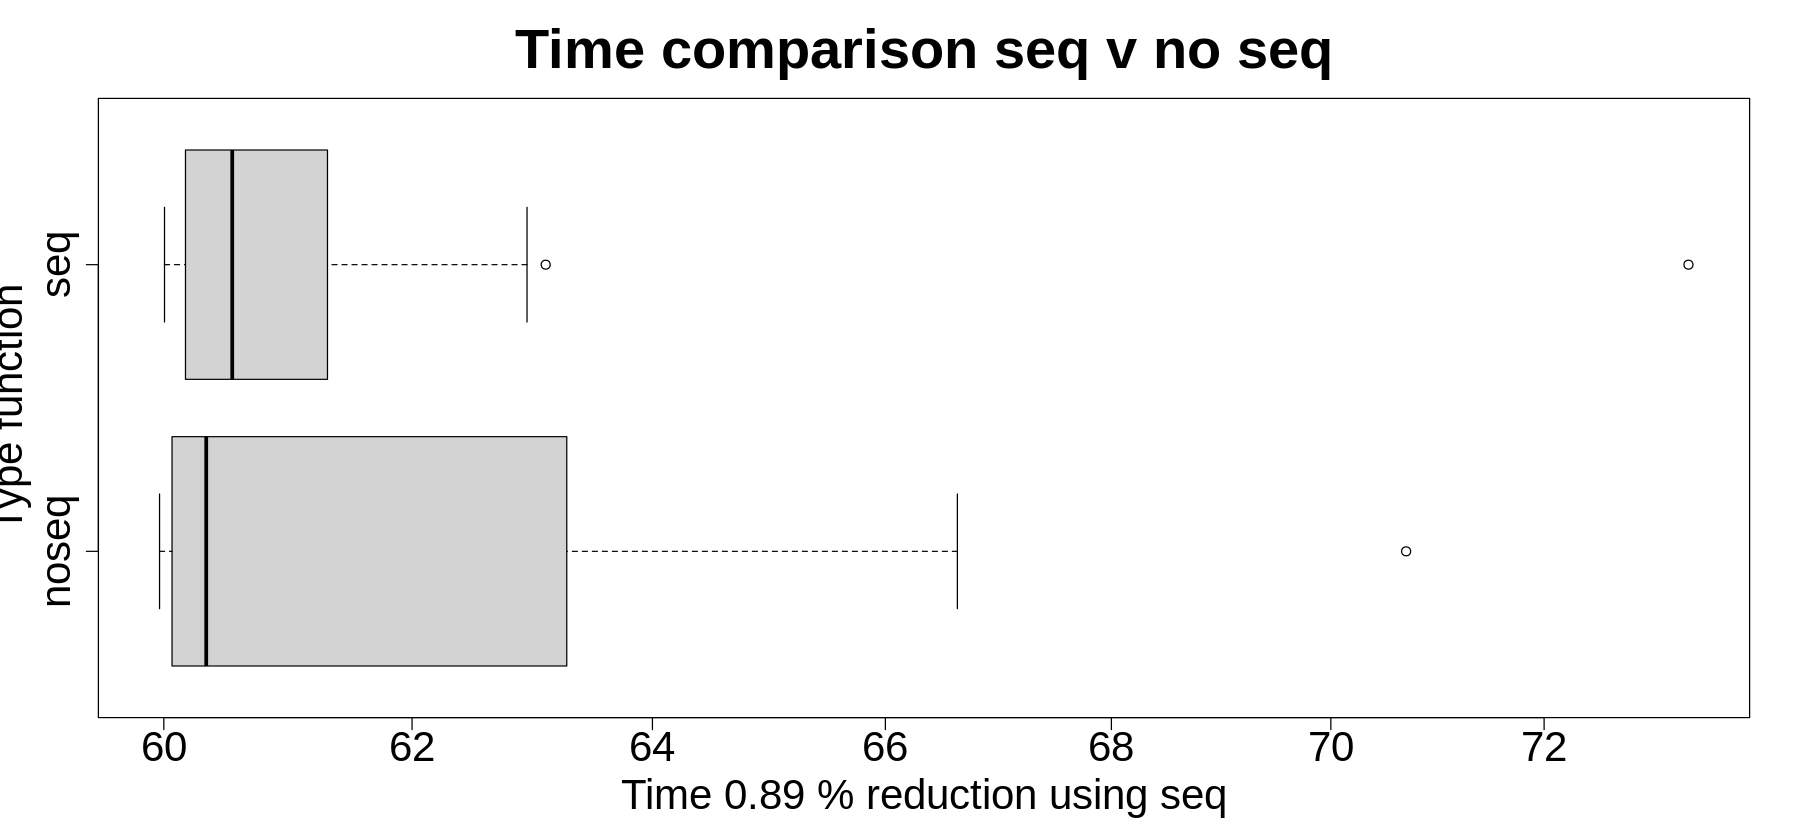

In [ ]:
m6 |>
boxplot(horizontal = TRUE, main = 'Time comparison seq v no seq',
     ylab = glue('Time {calcpecentage(m6)}'), xlab = 'Type function',
     cex.main = 2.8, cex.lab = 2.1, cex.axis = 2.1)

## **New pipe**

No need to call a library and no background translation

In [ ]:
set.seed(123)
demo <- data.frame(
  x = rnorm(10^6),
  y = rnorm(10^6),
  z = rnorm(10^6)
)
# Microbenchmarking native pipe vs dplyr pipe
m7 <- microbenchmark(
  native_pipe = {
    demo |>
      filter(x > 0) |>
      mutate(new_col = y * 2) |>
      summarise(avg_z = mean(z))
  },
  dplyr_pipe = {
    demo %>%
      filter(x > 0) %>%
      mutate(new_col = y * 2) %>%
      summarise(avg_z = mean(z))
  },
  times = 100
)
print(m7)

Unit: milliseconds
        expr      min       lq     mean   median       uq      max neval
 native_pipe 19.81718 23.55243 40.53121 28.98949 35.55023 162.8545   100
  dplyr_pipe 20.15864 23.55591 41.58933 29.85967 37.44190 185.3949   100


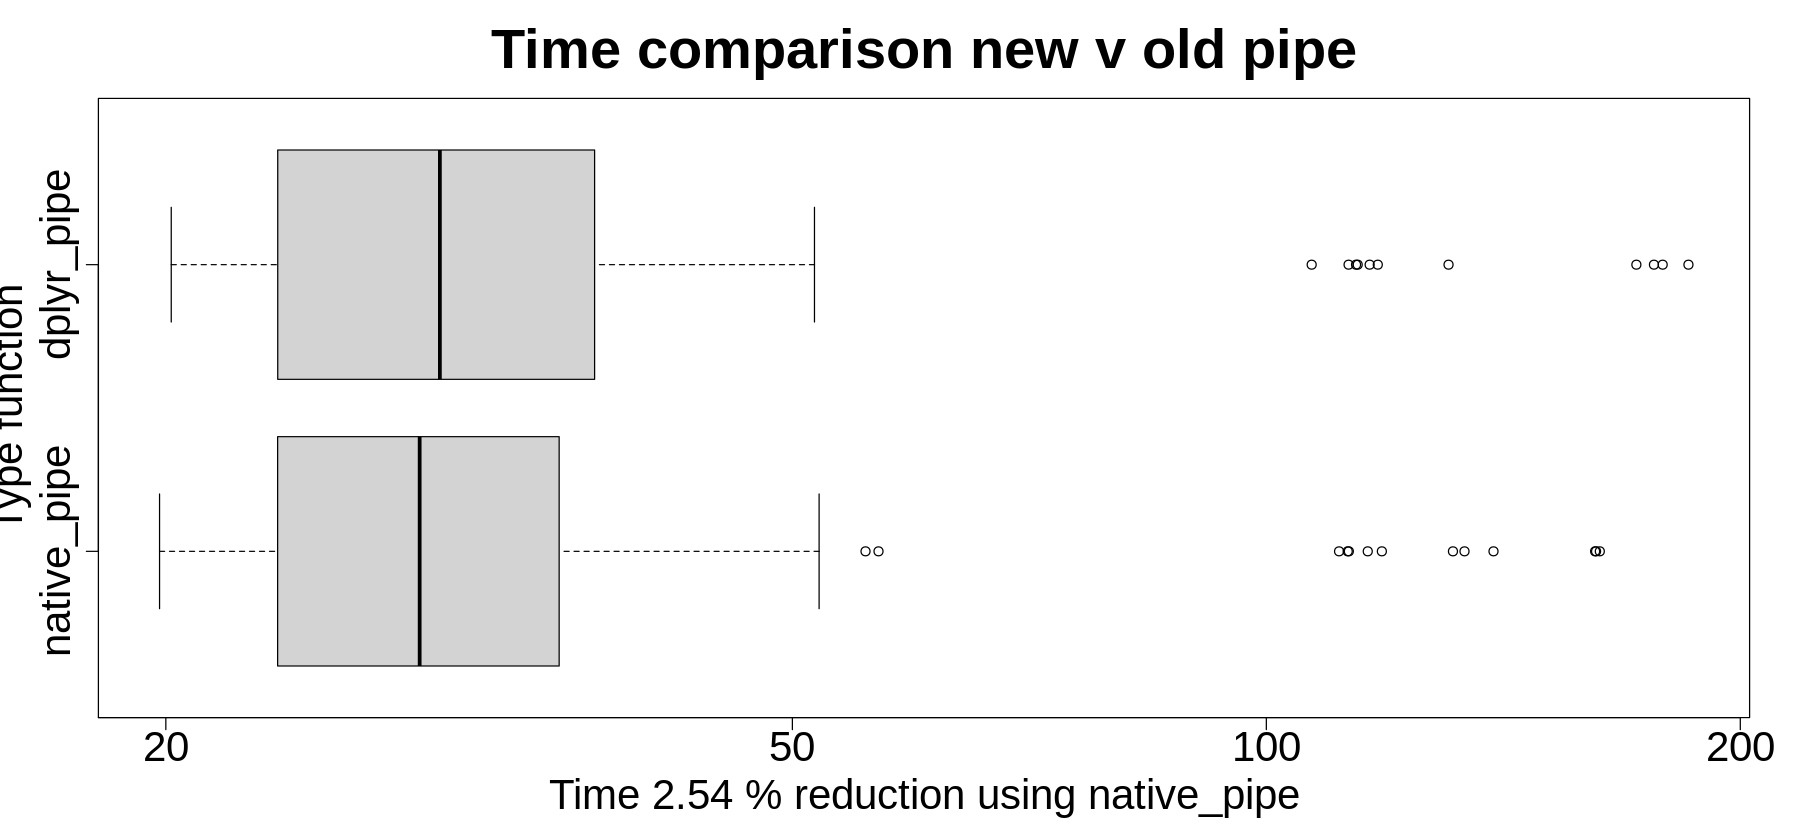

In [ ]:
m7 |>
boxplot(horizontal = TRUE, main = 'Time comparison new v old pipe',
     ylab = glue('Time {calcpecentage(m7)}'), xlab = 'Type function',
     cex.main = 2.8, cex.lab = 2.1, cex.axis = 2.1)